# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

Увага! В цьому наборі завдань для простоти експериментів ми будемо спочатку робити векторизацію на всьому наборі даних, а потім розбивку на train i test. В робочих проєктах ми теж можемо використати цей підхід для швидшої побудови PoC (proof of concept). Але фінальне рішення, яке ми будемо деплоїти - треба проводити за правилом - спочатку розбивка на трейн і тест, потім пишемо обробку для трейну, навчаємо векторизатори. І потім використовуємо готові векторизатори для тесту і всіх даних на етапі передбачення (інференсу).

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('tweet-sentiment-extraction/train.csv')

print('Show first 5 rows of the dataframe:\n')
data.head()

Show first 5 rows of the dataframe:



,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [27]:
print('Infromation about dataframe:\n')
data.info()

Infromation about dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [28]:
print('Count of missing values in each column:\n')
data.isnull().sum()

Count of missing values in each column:



textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [29]:
print('Deleting rows with missing values\n')
data = data.dropna()

Deleting rows with missing values



### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



Count of each class in sentiment column:

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64


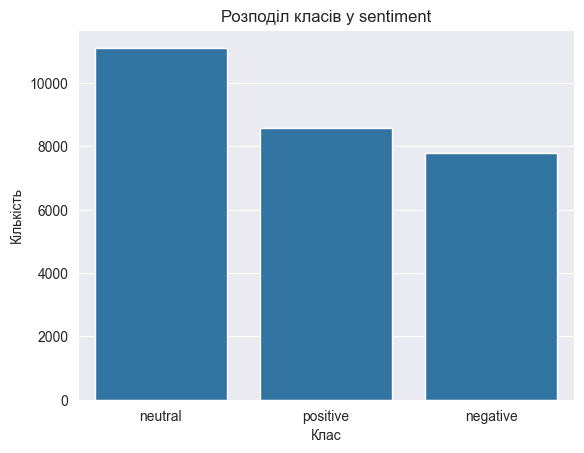

In [30]:
print('Count of each class in sentiment column:\n')
print(data['sentiment'].value_counts())

sns.countplot(data=data, x='sentiment', order=data['sentiment'].value_counts().index)
plt.title('Розподіл класів у sentiment')
plt.xlabel('Клас')
plt.ylabel('Кількість')
plt.show()


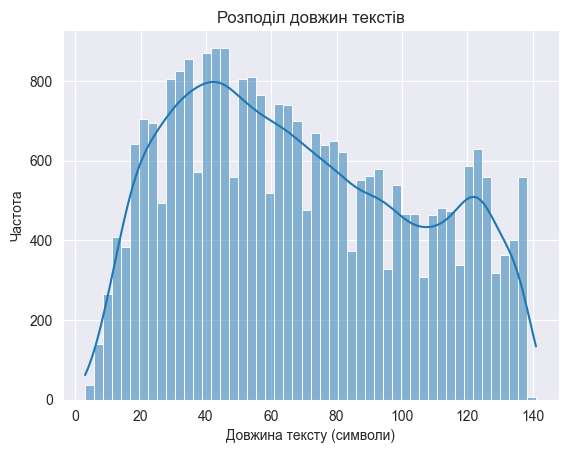

In [31]:
data['text_length'] = data['text'].astype(str).apply(len)

sns.histplot(data['text_length'], bins=50, kde=True)
plt.title('Розподіл довжин текстів')
plt.xlabel('Довжина тексту (символи)')
plt.ylabel('Частота')
plt.show()

### Висновок
З розподілу видно, що більшість текстів в символлах приблизно ~40-50 символів.
Є піки посля 100 символів, але їх не так багато.


### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dmytro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/dmytro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Унікальних слів: 17783
Топ-20 слів:
[('day', 2417), ('go', 2373), ('get', 1911), ('good', 1589), ('work', 1521), ('love', 1478), ('like', 1457), ('got', 1258), ('http', 1243), ('today', 1149), ('time', 1095), ('one', 1067), ('lol', 1015), ('happi', 1010), ('want', 983), ('thank', 977), ('know', 975), ('miss', 964), ('u', 944), ('realli', 915)]


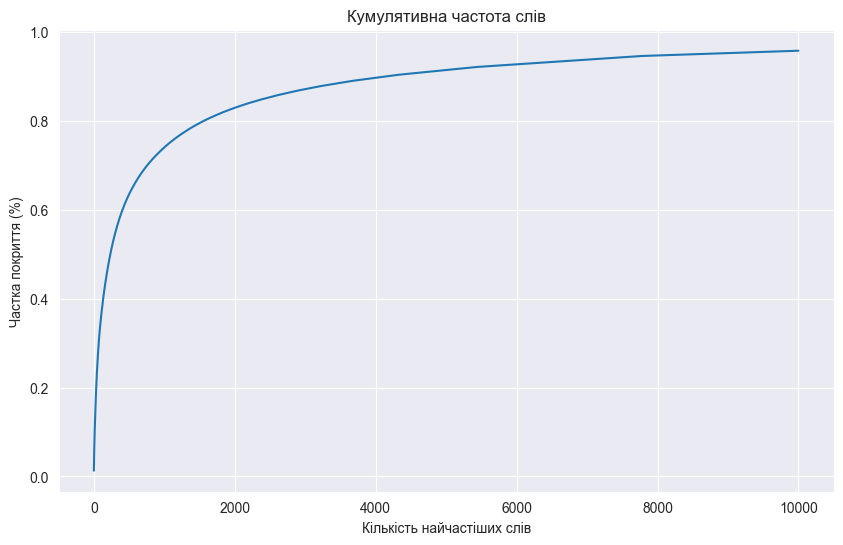

In [32]:
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
from nltk.tokenize import word_tokenize


language = 'english'
nltk.download('stopwords')
nltk.download('punkt')

stopwords = stopwords.words(language)
stemmer = SnowballStemmer(language)

def tokenize(text):
    tokens = word_tokenize(text.lower())
    tokens = [stemmer.stem(w) for w in tokens if w.isalpha() and w not in stopwords]
    return tokens

all_tokens = []
for text in data['text'].astype(str):
    all_tokens.extend(tokenize(text))


# Підрахунок частот
token_counts = Counter(all_tokens)
print("Унікальних слів:", len(token_counts))
print("Топ-20 слів:")
print(token_counts.most_common(20))

freqs = np.array(sorted(token_counts.values(), reverse=True))
cum_freq = np.cumsum(freqs) / freqs.sum()

plt.figure(figsize=(10, 6))
plt.plot(cum_freq[:10000])
plt.xlabel('Кількість найчастіших слів')
plt.ylabel('Частка покриття (%)')
plt.title('Кумулятивна частота слів')
plt.grid(True)
plt.show()

Основуючись на частоті слів, то виберемо 6000 фіч (слов) для навчання.

In [33]:
max_features = 6000

vectorizer = CountVectorizer(lowercase=True,
                             tokenizer=tokenize,
                             stop_words=stopwords,
                             max_features=max_features)
X_bow = vectorizer.fit_transform(data['text'])

vectorizer.get_feature_names_out()

/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


array(['aaaah', 'aaah', 'aaahhh', ..., 'zone', 'zoo', 'zzzz'],
      dtype=object)

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [34]:
from sklearn.model_selection import train_test_split

y = data['sentiment']

X_train_bow, X_test_bow, y_train, y_test = train_test_split(
    X_bow, y, test_size=0.3, stratify=y, random_state=42
)

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_bow, y_train)

y_pred_lr = lr.predict(X_test_bow)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression:
              precision    recall  f1-score   support

    negative       0.70      0.62      0.66      2334
     neutral       0.63      0.72      0.67      3335
    positive       0.75      0.70      0.73      2575

    accuracy                           0.69      8244
   macro avg       0.70      0.68      0.69      8244
weighted avg       0.69      0.69      0.69      8244



In [36]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=30)
dt.fit(X_train_bow, y_train)

y_pred_dt = dt.predict(X_test_bow)
print("Decision Tree:")
print(classification_report(y_test, y_pred_dt))

Decision Tree:
              precision    recall  f1-score   support

    negative       0.77      0.38      0.51      2334
     neutral       0.56      0.84      0.67      3335
    positive       0.77      0.62      0.69      2575

    accuracy                           0.64      8244
   macro avg       0.70      0.61      0.62      8244
weighted avg       0.68      0.64      0.63      8244



In [37]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [38]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb = XGBClassifier(
    random_state=42,
    seed=2,
    colsample_bytree=0.6,
    subsample=0.7
)

# Randomized search
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1
)

search.fit(X_train_bow, y_train_encoded)

best_xgb = search.best_estimator_

y_pred = best_xgb.predict(X_test_bow)
print("Best hyperparameters for XGBoost:", search.best_params_)
print("BoW Classification Report:")
print(classification_report(y_test, le.inverse_transform(y_pred)))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best hyperparameters for XGBoost: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.3, 'colsample_bytree': 1.0}
Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.60      0.67      2334
     neutral       0.65      0.77      0.70      3335
    positive       0.77      0.73      0.75      2575

    accuracy                           0.71      8244
   macro avg       0.72      0.70      0.71      8244
weighted avg       0.72      0.71      0.71      8244



### Висновок
Після проведення аналізу, то обираємо XGBoost звичайно, бо ця модель дає кращі результати, бо ми ще знайшли найкращі параметри під неї.
Під час вибору моделі орієнтувався на f1-score в данному випадку.

Щодо самої моделі, то вона має добпу збалансованру якість між negative, neutral та positive., відповідоно 0.67, 0.70, 0.75 F1-score. Це непоганий результат для мультикласових завдань в даному випадку. Accuracy 0.70 - означає, що модель правильно класифікує 70% даних. Це не погано, але можна і краще звичайно. Тобто типічний accuracy для NLP завдань в діапозоні 0.7-0.9.

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [39]:
feature_names = vectorizer.get_feature_names_out()

importances = best_xgb.feature_importances_

feat_imp_df = pd.DataFrame({
    'token': feature_names,
    'importance': importances
})

# Сортуємо за важливістю
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)
feat_imp_df

,token,importance
2266,happi,0.007717
5209,thank,0.007274
2293,hate,0.006706
155,amaz,0.005217
1681,enjoy,0.004839
...,...,...
2312,hdd,0.000000
2311,hd,0.000000
2310,hbu,0.000000
2309,haz,0.000000


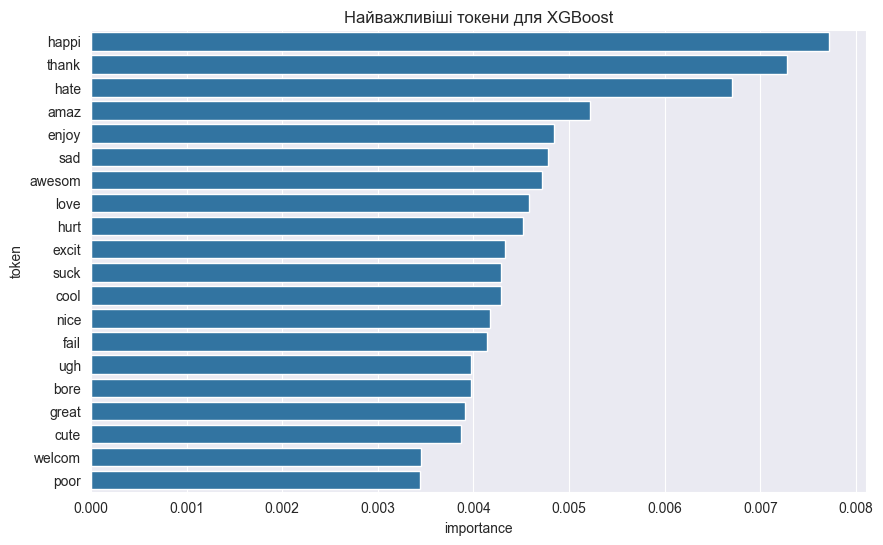

In [40]:
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(20), x='importance', y='token')
plt.title('Найважливіші токени для XGBoost')
plt.show()

### Висновок

Дійсно усі слова несуть емоційну забавленість, тому логічно припустити, що модель гарно працює.

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    stop_words=stopwords,
    max_features=max_features
)

X_tfidf = tfidf_vectorizer.fit_transform(data['text'])

/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/dmytro/Code/MachineLearning/machine-learning-for-humans-2.0/.env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [45]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y, test_size=0.3, stratify=y, random_state=42
)

y_train_tfidf_enc = le.transform(y_train_tfidf)
y_test_tfidf_enc = le.transform(y_test_tfidf)

In [52]:
xgb_tfidf = XGBClassifier(
    random_state=42,
    seed=2,
    colsample_bytree=0.6,
    subsample=0.7
)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Randomized search
search_tfidf = RandomizedSearchCV(
    estimator=xgb_tfidf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1
)

search_tfidf.fit(X_train_tfidf, y_train_tfidf_enc)

best_xgb_tfidf = search_tfidf.best_estimator_

y_pred_tfidf = best_xgb_tfidf.predict(X_test_tfidf)
print("Best hyperparameters for XGBoost (TF-IDF):", search_tfidf.best_params_)
print("TF-IDF XGBoost Classification Report:")
print(classification_report(y_test_tfidf, le.inverse_transform(y_pred_tfidf)))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best hyperparameters for XGBoost (TF-IDF): {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
F-IDF XGBoost Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.57      0.65      2334
     neutral       0.63      0.77      0.69      3335
    positive       0.76      0.71      0.73      2575

    accuracy                           0.69      8244
   macro avg       0.72      0.68      0.69      8244
weighted avg       0.71      0.69      0.69      8244



In [54]:
# Важливість слів у TF-IDF моделі
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
importances_tfidf = best_xgb_tfidf.feature_importances_

df_imp_tfidf = pd.DataFrame({
    'token': tfidf_feature_names,
    'importance': importances_tfidf
}).sort_values(by='importance', ascending=False)

print("TF-IDF — Топ 20 слів:")
df_imp_tfidf

TF-IDF — Топ 20 слів:


,token,importance
5209,thank,0.005716
2266,happi,0.005688
155,amaz,0.005002
2293,hate,0.004864
2543,hurt,0.004410
...,...,...
2206,gurl,0.000000
2205,gunna,0.000000
2204,guna,0.000000
2203,gun,0.000000


In [55]:
bow_top = set(feat_imp_df.head(20)['token'])
tfidf_top = set(df_imp_tfidf.head(20)['token'])

common = bow_top & tfidf_top
only_bow = bow_top - tfidf_top
only_tfidf = tfidf_top - bow_top

print("🔁 Спільні токени:", common)
print("❌ Лише у BoW:", only_bow)
print("✅ Лише у TF-IDF:", only_tfidf)

🔁 Спільні токени: {'nice', 'thank', 'awesom', 'hurt', 'enjoy', 'great', 'happi', 'hate', 'excit', 'ugh', 'cute', 'fail', 'sad', 'love', 'amaz', 'bore', 'suck'}
❌ Лише у BoW: {'poor', 'cool', 'welcom'}
✅ Лише у TF-IDF: {'fantast', 'stupid', 'sick'}


### Висновок

Після classification report можна побачити, що модель TF-IDF поводиться гірше за BoW в данному випадку.

Модель XGBoost на BoW показала кращі результати, ніж на TF-IDF:
- Accuracy: 0.71 (проти 0.69)
- Macro F1: 0.71 (проти 0.69)

Тож в даному випадку модель на BoW (зрозуміло, що на XGBoost із гіперпараметрами) показала кращі результати і її вибрав би для продакшину.

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [82]:
df_errors = pd.DataFrame({
    'text': data.loc[y_test.index, 'text'].values,
    'true': y_test.values,
    'pred': le.inverse_transform(y_pred)
})

# Фільтруємо лише помилки
df_mistakes = df_errors[df_errors['true'] != df_errors['pred']]
print(f"Кількість помилок: {len(df_mistakes)} з {len(y_test)} ({len(df_mistakes) / len(y_test) * 100:.2f}%)")

df_mistakes.sample(20, random_state=42)

Кількість помилок: 2412 з 8244 (29.26%)


,text,true,pred
5568,i wish i had friends i could spend the night ...,negative,positive
7546,Exhausted. Thank goodness my race is almost he...,neutral,positive
8188,You`re welcome! How much longer until it`s c...,neutral,positive
6656,OMFG my favourite jerk chicken place closed,negative,neutral
6138,"Couldn`t see one, but I`m probably blind Do ...",negative,neutral
3600,"_Bee same here : / Coincidently, my friend j...",negative,neutral
6344,This definitely separates a professional robb...,negative,neutral
6039,? Polly Scattergood`s new single out today! Do...,positive,neutral
5696,Home w/bae & Myka.. He`s so meann,negative,neutral
2617,twit twit twitter! trying to 'legally' watch a...,negative,neutral


In [80]:
df_mistakes[(df_mistakes['true'] == 'negative') & (df_mistakes['pred'] == 'positive')].sample(10, random_state=42)

,text,true,pred
6687,good morning twitterworld! slept too less..,negative,positive
2482,He still doesn`t love me... I won`t ask again,negative,positive
7652,wishing I was anywhere but here...,negative,positive
935,Visiting family in hospital = not fun,negative,positive
5758,Me and Wendy are going after all. Wish you w...,negative,positive
671,Oh no! I just read they are going to do a rema...,negative,positive
4385,wtf?! my tweets aren`t posting super excited...,negative,positive
1521,I wish I could just go for a drive..or a movie...,negative,positive
4656,no decleration yet but crazy **** Koreans are...,negative,positive
372,i realy wanted to go out cause its so nice but...,negative,positive


### Висновок
Із того, що бачу, то деякі слова як fun, love із not часто використовуються в негативному контексті, тож модель тут погано передбачає. Бачу, що к-сть символів також дають емоційне забарвлення як то **** або !!! в кінці речення.

Також бачу, що lowercase додався у нас при визначені, хоча також uppercase давав негативне забарвлення, хоча у нас класифікатор визначав як нейтральне.

Можливо, що якісь скорочення/сленгові слова дають такод забарвлення і їх можна завчасно визначити.

Тобто аналізувати взагалі десь повне речення і шукати по сенсу із іншими.

Ще можна звичайно усі документи проаналізувати (тобто не 6000 токенів все ж, а усі використати для аналізу.


І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model